# Analysis and Measurements of Co-Occurance Matrix Recommendations

In [2]:
import segmentation_models_pytorch as smp

In [3]:
import cv2
import torch
import numpy as np
import albumentations as album
import segmentation_models_pytorch as smp


class_names = ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

import math
colors = [
    ("black", (0, 0, 0)),
    ("silver", (192, 192, 192)),
    ("gray", (128, 128, 128)),
    ("white", (255, 255, 255)),
    ("maroon", (128, 0, 0)),
    ("red", (255, 0, 0)),
    ("purple", (128, 0, 128)),
    ("fuchsia", (255, 0, 255)),
    ("green", (0, 128, 0)),
    ("lime", (0, 255, 0)),
    ("olive", (128, 128, 0)),
    ("yellow", (255, 255, 0)),
    ("navy", (0, 0, 128)),
    ("blue", (0, 0, 255)),
    ("teal", (0, 128, 128)),
    ("aqua", (0, 255, 255)),
    ("brown", (150, 75, 0)),
    ("orange", (255, 165, 0)),
]

def distance(a,b):
    dx = a[0]-b[0]
    dy = a[1]-b[1]
    dz = a[2]-b[2]
    return math.sqrt(dx*dx+dy*dy+dz*dz)

def findclosest(pixel):
    mn = 999999
    for name,rgb in colors:
        d = distance(pixel, rgb)
        if d < mn:
            mn = d
            color = name
    return color


def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def get_rgb(img, mask):
    r = img[:, :, 0][mask].mean()
    g = img[:, :, 1][mask].mean()
    b = img[:, :, 2][mask].mean()
    return r, g, b

remove_items = {
    "M" : [
        'blouse',
        'bra',
        'cape',
        'dress',
        'flats',
        'heels',
        'intimate',
        'leggings',
        'panties',
        'pumps',
        'purse',
        'romper',
        'skirt',
        'tights',
        'top',
        'wedges'
    ],
    "F" : [
        'vest',
        'wallet',
        'watch'
    ]
}


def update_matrix(matrix, scaler):
    updated_matrix = matrix.copy()
    for item, count in scaler.items():
        idx = combos_idx[item]
        updated_matrix[:, idx] = updated_matrix[:, idx] + 1
        updated_matrix[:, idx] = updated_matrix[:, idx] * count
    return updated_matrix

def get_recommendations(query_items, matrix, gender="other", n=10):
    response = np.zeros(len(combos))
    for item in query_items:
        idx = combos_idx[item]
        response = response + matrix[idx]
    for item in query_items:
        idx = combos_idx[item]
        response[idx] = 0
    if gender != "other":
        for item in remove_items[gender]:
            for color in color_labels:
                idx = combos_idx[color+" "+item]
                response[idx] = 0

    idx_sort = response.argsort()
    combos_ = np.array(combos)
    response = combos_[idx_sort[::-1]][:n]

    return [color+" "+item for color, item in response]

from itertools import product

dont_include = ("null", "accessories", "hair", "skin")
dont_include_idx = (0, 1, 19, 41)
items = {tag: i for i, tag in enumerate(class_names) if tag not in dont_include}
color_labels = [color for color, _ in colors]
item_labels = [item for item, _ in items.items()]

combos = list(product(color_labels, item_labels))
combos_idx = {
    color+" "+item: i for i, (color, item) in enumerate(combos)
}

matrix = np.fromfile('matrix.dat', dtype=int).reshape(
    len(combos), len(combos)
)

def get_custom_recommendations(query_items, context_items, gender="other", n=10):
    updated_matrix = update_matrix(
        matrix, context_items
    )
    response = get_recommendations(query_items, updated_matrix, gender=gender, n=n)
    return response

In [4]:
def relevant_items(output, expected):
    return list(set(output).intersection(set(expected)))

def fp(output, expected):
    return list(set(output).difference(set(expected)))

def get_precision(output, expected):
    relevant = relevant_items(output, expected)
    total = output
    return len(relevant)/len(total)

def get_recall(output, expected):
    relevant = relevant_items(output, expected)
    total = expected
    return len(relevant)/len(total)

def get_fpr(output, expected, input):
    false_positives = fp(output, expected)
    total = matrix.shape[0] - len(expected) - len(input)
    return len(false_positives)/total

In [6]:
import os
import pandas as pd
class_dict = pd.read_csv(os.path.join('data', 'class_dict.csv'))
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()
select_classes = ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit',
                  'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress',
                  'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie',
                  'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace',
                  'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf',
                  'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings',
                  'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie',
                  'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

In [8]:
%%time

import os, cv2

eval_dataset = {}
files = os.listdir(f"data/labels/pixel_level_labels_colored/")
for fnum, file_name in enumerate(files):
    segmentations = cv2.imread(f"data/labels/pixel_level_labels_colored/{file_name}")[:,:,::-1]
    img = cv2.imread(f"data/images/{file_name[:-4]}.jpg")

    mask = reverse_one_hot(one_hot_encode(segmentations, class_rgb_values).astype('float'))

    img_items = np.unique(mask)
    img_items = [x for x in img_items if x not in (0, 1, 19, 41)]

    img_color_items = []
    for n in img_items:
        item = select_classes[n]
        r, g, b = get_rgb(img, mask==n)
        color = findclosest([r, g, b])
        img_color_items += [color+" "+item]

    eval_dataset[file_name[:-4]] = img_color_items
    if not fnum%10:
        print(f"{fnum} of {len(files)} done.")
    if fnum == 100:
        break

0 of 1004 done.
10 of 1004 done.
20 of 1004 done.
30 of 1004 done.
40 of 1004 done.
50 of 1004 done.
60 of 1004 done.
70 of 1004 done.
80 of 1004 done.
90 of 1004 done.
100 of 1004 done.
CPU times: user 1min 53s, sys: 7.69 s, total: 2min
Wall time: 2min 1s


In [9]:
from random import shuffle, randint

def get_precision_recall_fpr(k):
    precision = []
    recall = []
    fpr = []
    for file, data in eval_dataset.items():
        if len(data) <= 1:
            continue
        idx = randint(1, len(data) - 1)
        query =  data[:idx]
        expected = data[idx:]

        output = get_recommendations(query, matrix, n=k)
        precision.append(get_precision(output, expected))
        recall.append(get_recall(output, expected))
        fpr.append(get_fpr(output, expected, query))

    precision = np.mean(precision)
    recall = np.mean(recall)
    fpr = np.mean(fpr)
    return precision, recall, fpr

def get_roc(k_sweep=10):
    precision = []
    recall = []
    fpr = []
    for k in range(1, k_sweep+1):
        precision_k, recall_k, fpr_k = get_precision_recall_fpr(k)
        precision.append(precision_k)
        recall.append(recall_k)
        fpr.append(fpr_k)
    return precision, recall, fpr

In [10]:
p, r, fpr = get_roc(200)

(0.0, 1.0)

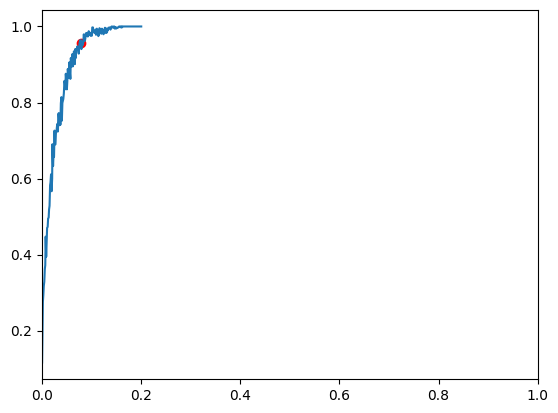

In [12]:
import matplotlib.pyplot as plt
p10, r10, fpr10 = get_precision_recall_fpr(80)
plt.plot(fpr, r)
plt.scatter(fpr10, r10, color='r')
plt.xlim([0, 1])


(0.0, 1.0)

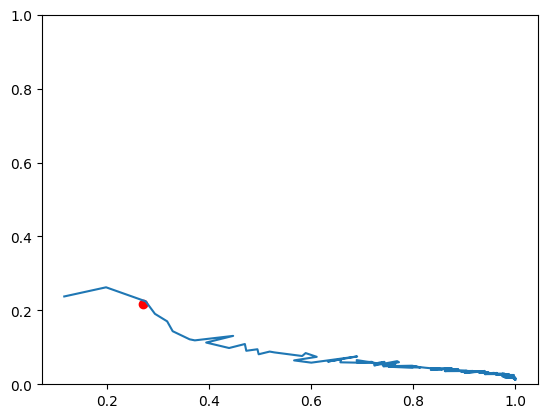

In [13]:
p10, r10, fpr10 = get_precision_recall_fpr(3)
plt.plot(r, p)
plt.scatter(r10, p10, color='r')
plt.ylim([0, 1])

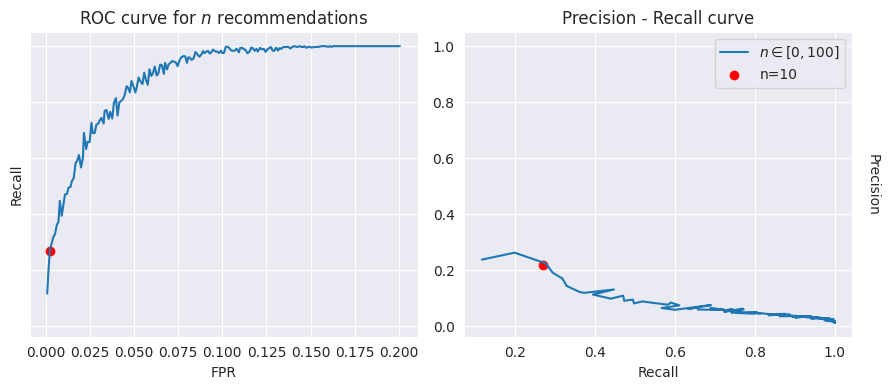

In [16]:
import seaborn as sns
sns.set_style("darkgrid")
fig = plt.figure(figsize=(9,4))
ax1 = plt.subplot(1, 2, 1)
plt.plot(fpr, r, label = '$n\in [1, 100]$')
plt.scatter(fpr10, r10, label = 'n=10', color='r')
plt.xlabel('FPR')
plt.ylabel('Recall')
plt.title('ROC curve for $n$ recommendations')
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plt.plot(r, p, label = '$n\in [0, 100]$')
plt.scatter(r10, p10, label = 'n=10', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision', rotation=-90, labelpad=20)
plt.title('Precision - Recall curve')
plt.legend(loc='best')
ax2.yaxis.set_label_position("right")
ax1.tick_params(labelleft=False)
plt.tight_layout()
plt.show()
fig.savefig(f"roc.pdf", format="pdf", dpi=1200)
fig.savefig(f"roc.png", format="png", dpi=1200)